In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import ArtistAnimation
import random
from skimage import io
import heapq

#plt.rcParams['text.usetex'] = True
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'

Circular Track Sanity Check

In [3]:
class TrafficSimulation:

    def __init__(self, road_length=20, car_density=0.1, prob_slow=0.2,
                 max_speed=5):
        '''
        Create a new traffic simulation object. Cars are distributed randomly
        along the road and start with random velocities.

        Inputs:

            road_length (int) The number of cells in the road. Default: 100.

            car_density (float) The fraction of cells that have a car on them.
              Default: 0.2.

            prob_slow (float) The probability that a car will randomly slow down
              by 1 during an update step. Default: 0.5.

            max_speed (int) The maximum speed in car cells per update step.
              Default: 5.
        '''

        np.random.seed(1234)

        self.road_length = road_length
        self.car_density = car_density
        self.max_speed = max_speed
        self.prob_slow = prob_slow

        # Create an empty road: -1 means empty in this simulation
        self.state = np.full(self.road_length, -1, dtype=int)
        # Choose random locations to place cars
        random_indexes = np.random.choice(
            range(self.road_length),
            size=int(round(car_density * self.road_length)),
            replace=False)
        # Give each car a random initial speed from 0 to max_speed
        self.state[random_indexes] = np.random.randint(
            0, self.max_speed + 1, size=len(random_indexes))

        # Keep track of the time steps and average traffic flow at each step
        self.time_step = 0
        self.average_traffic_flow = []

        self.previous_states = []

    def update_optimized(self):
        '''
        Advance one time step in the simulation.
        '''
        # Get the location of each car
        car_indexes = np.where(self.state >= 0)[0]
        
        # If there are no cars, we have nothing to update
        if len(car_indexes) == 0:
            self.average_traffic_flow.append(0)
            self.time_step += 1
            return

        # Get the speed of each cars
        car_speeds = self.state[car_indexes]
        # Get the distance from each car to the next car
        car_distances = np.ediff1d(
            np.concatenate((car_indexes,
                            [car_indexes[0] + self.road_length])))
        # Update car speeds
        # Acceleration
        car_speeds = np.where(
            car_speeds + 1 <= self.max_speed,
            car_speeds + 1,
            self.max_speed)
        # Deceleration
        car_speeds = np.where(
            car_speeds >= car_distances,
            car_distances - 1,
            car_speeds)
        # Randomization
        moving_car_indexes = np.where(car_speeds > 0)[0]
        car_speeds[moving_car_indexes] -= (
            np.random.uniform(size=len(moving_car_indexes)) < self.prob_slow)

        # Move cars forward using their new speeds
        car_indexes += car_speeds
        car_indexes %= self.road_length
        self.state.fill(-1)
        self.state[car_indexes] = car_speeds

        # Update traffic flow history
        self.average_traffic_flow.append(sum(car_speeds) / self.road_length)
        self.time_step += 1

        self.previous_states.append(np.array(self.state))

    def display(self):
        '''
        Print out the current state of the simulation.
        '''
        prev = self.previous_states

        fig, ax  = plt.subplots(1,1, figsize= (3,3))

        for i in range(len(prev)):
            # Filter out empty cells
            y_cars = np.arange(0, len(prev[i]))[prev[i] != -1]
            
            t = [i]*len(y_cars)
            t_points = list(zip([0]*len(y_cars), y_cars))

            c = prev[i][prev[i] != -1]

            # Make colorbar a func of speed
            a = ax.scatter(y_cars, t, c = c, alpha = 0.6, marker = 'o', cmap='bone_r')

        ax.set_yticks(range(len(prev)))
        ax.set_axis_off()
        ax.set_title(f'Space-Time Diagram after {self.time_step} steps')


        #plt.colorbar(a)
        plt.gca().invert_yaxis()
        plt.show()


        return fig, ax

Separate representation of the board from the logic.
Each lane is a 1D NaSch sim

In [14]:
class Lane:
    # a 1D Nagel-Schreckenberg simulation using Cars
    def __init__(self, env, road_length = 20, car_density = 0.7, max_speed = 5, prob_slow = 0.2, anchor = 50, direction = 'NS') -> None:
        self.road_length = road_length

        self.direction = direction
        self.anchor = anchor
        
        # TODO: arrival_rate based on empirical prior
        self.env = env

        self.representation = np.full(self.road_length, -1, dtype=int)
        self.previous_states = []

        # Init cars or road based on Lane params // speeed limits vary by lane
        self.car_density = car_density
        self.max_speed = max_speed
        self.prob_slow = prob_slow

        self.cars = []
        car_idxs = np.random.choice(
                range(self.road_length),
                size=int(round(car_density * self.road_length)),
                replace=False)

        for i in car_idxs:
            velocity_i = np.random.randint(0 , self.max_speed + 1)
            new_car = Car(position = i,
                        velocity = velocity_i,
                        max_speed = self.max_speed, 
                        prob_slow = self.prob_slow)
            heapq.heappush(self.cars, new_car)

    def set_representation(self):
        # get positions of cars, set index
        new_representation = np.full(self.road_length, -1, dtype=int)

        for car in self.cars:
            car_idx = car.position
            car_vel = car.velocity

            new_representation[car_idx] = car_vel

        self.previous_states.append(new_representation)
        self.representation = new_representation

        return

        
    def display(self):
        #self.set_representation()
        print(''.join('.' if x == -1 else str(x) for x in self.representation))

    def update(self):
        # calculate next_pos
        cars_ = sorted(self.cars)

        for i, car in enumerate(sorted(self.cars)):
            next_car  = cars_[(i + 1) % len(self.cars)]

            dist = (next_car.position - car.position) % self.road_length
            car.calc_next_position(dist)

        # set next_pos
        for car in self.cars:
            car.update_position(self.road_length)

        self.set_representation()

    def show_lane(self, axs = False):

        prev = self.previous_states

        if axs: 
            for i in range(len(prev)):
                # Filter out empty cells
                y_cars = np.arange(0, len(prev[i]))[prev[i] != -1]
                
                t = [i]*len(y_cars)
                t_points = list(zip([0]*len(y_cars), y_cars))

                c = prev[i][prev[i] != -1]

                # Make colorbar a func of speed
                a = axs.scatter(y_cars, t, c = c, alpha = 0.6, marker = 'o', cmap='bone_r')
                axs.set_yticks(range(len(prev)))
                axs.set_axis_off()
                axs.set_title(f'{self.anchor} {self.direction} after {self.env.curr_time} Steps')

                plt.gca().invert_yaxis()
        else:
            fig, ax  = plt.subplots(1,1, figsize= (3,3))
            for i in range(len(prev)):
                # Filter out empty cells
                y_cars = np.arange(0, len(prev[i]))[prev[i] != -1]
                
                t = [i]*len(y_cars)
                t_points = list(zip([0]*len(y_cars), y_cars))

                c = prev[i][prev[i] != -1]

                # Make colorbar a func of speed
                a = ax.scatter(y_cars, t, c = c, alpha = 0.6, marker = 'o', cmap='bone_r')

            ax.set_yticks(range(len(prev)))
            ax.set_axis_off()
            ax.set_title(f'{self.anchor} {self.direction} after {self.env.curr_time} Steps')

            plt.gca().invert_yaxis()
        
        return 
          
class Environment:
    # Variables of sim and current time
    def __init__(self, road_length, car_density, max_speed, prob_slow, n_lanes = 1) -> None:
        self.curr_time = 0

        self.lanes = []

        if n_lanes > 1:

            anchors = np.random.choice(np.arange(0,road_length), size = n_lanes, replace = False)
            directions = np.random.choice(["NS", "EW", "WE", "SN"], size = n_lanes, replace = True)

            print(anchors)

            for i in range(n_lanes):
                new_lane = Lane(self, 
                                road_length = road_length, 
                                car_density = car_density, 
                                max_speed = max_speed, 
                                prob_slow = prob_slow, 
                                anchor = anchors[i], 
                                direction = directions[i])
                self.lanes.append(new_lane)

        else: 
            new_lane = Lane(self, 
                                road_length = road_length, 
                                car_density = car_density, 
                                max_speed = max_speed, 
                                prob_slow = prob_slow, 
                                anchor = 50, 
                                direction = "NS")
            self.lanes.append(new_lane)

        self.env_rep = np.full((road_length, road_length), -2)

    def update(self):
        for lane in self.lanes:
            # update 
            lane.update()
        # increment time
        self.curr_time += 1


    # TODO: invert SN and WE
    def update_representation(self):
        new_rep = self.env_rep.copy()

        for lane in self.lanes:
            if lane.direction == 'NS' or lane.direction == 'SN' :
                new_rep[:, lane.anchor] = lane.representation
            elif lane.direction == 'EW' or lane.direction == 'WE' :
                new_rep[lane.anchor, :] = lane.representation

        self.env_rep = new_rep

        return self.env_rep

    def show_board(self, ax = False):

        self.update_representation()
        
        if ax:
            return ax.imshow(self.env_rep, cmap = 'gray_r')
        else:
            return plt.imshow(self.env_rep, cmap = 'gray_r')
 


class Car:
    def __init__(self, position, velocity, max_speed, prob_slow) -> None:
        self.position = position
        self.velocity = velocity

        self.next_velocity = velocity
        self.max_speed = max_speed
        self.prob_slow = prob_slow

        self.history = []

    def __lt__(self, other):
        return self.position < other.position

    def __repr__(self) -> str:
        return f'Car at {self.position} with {self.velocity} cells/step'   

    def calc_next_position(self, dist):
        # Acceleration
        if self.velocity < self.max_speed:
            self.next_velocity = self.velocity + 1

        # Slow down
        if self.next_velocity >= dist:
            self.next_velocity = dist - 1

        # Random Transition Probability
        if self.next_velocity > 0:
            gamble = np.random.random() < self.prob_slow
            if gamble:
                self.next_velocity -= 1
    
    def update_position(self, max_length):
        self.velocity = self.next_velocity

        self.position += self.velocity
        self.position %= max_length

        self.history.append(self.velocity)


## np array vs class based comparison: Cars in a Loop

Implements time step incrementer, Car classes and representation. 

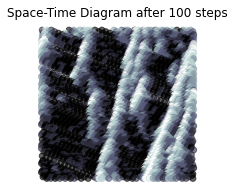

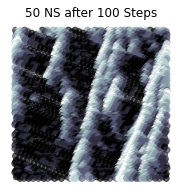

In [15]:
# Single Lane

# Set the seed so we can compare to numpy-based simulations
np.random.seed(1234)
n_steps = 100

init_params = {
    'road_length' : 200,
    'car_density' : 0.2,
    'max_speed': 5,
    'prob_slow': 0.2
}
OOP_sim = Environment(**init_params)
for i in range(n_steps):
    OOP_sim.update()

Scheffler_sim = TrafficSimulation(**init_params)
for i in range(n_steps):
    Scheffler_sim.update_optimized()

# How well do they match?
Scheffler_sim.display()
OOP_sim.lanes[0].show_lane()


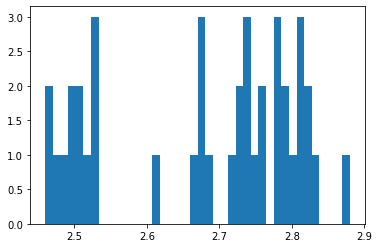

In [33]:
# average speeds over journey :: cyclic
plt.hist([np.mean(car.history) for car in OOP_sim.lanes[0].cars], bins = 40)
plt.show()

### Plots for Pigeon Viewing Pleasure

### Life in the Fast Lane

MovieWriter ffmpeg unavailable; using Pillow instead.


[186 181]


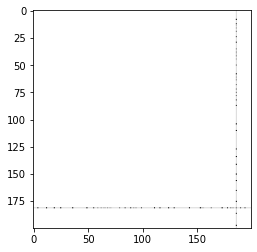

In [38]:
# Implement lanes with directionality
ev = Environment(**init_params, n_lanes= 2)

fig = plt.figure()

frames = []
for i in range(100):
    ev.update()
    ev.update_representation()

    frames.append([plt.imshow(ev.env_rep, animated = True, cmap = 'gray_r')])

ArtistAnimation(fig, frames).save("test.gif", fps = 30)

### Implementing a Traffic Light

In [ ]:
# If yes, place a traffic light

# take a set of lanes, calculate intersections
# for each intersection (x1,y1), (x2,y2)

# TrafficLight(x1,y1, lane1, lane 2)
#       lanes = [lane1, lane 2]
#       position = [x1,y1]


# Lane(end):
# end  = Intersection().1


# lane
# traffic lights


# Bd = 



# Traffic light phase
# 120 clicks: green
# 120 clicks: red

# Phase

# Road -> Interesection

# Environment

#Intersection.add_lane
# Lane . Intersections


# if car at lane

In [51]:
### Cars turn onto a road with fixed probability

class Lane:
    # a 1D Nagel-Schreckenberg simulation using Cars
    def __init__(self, env, road_length = 20, car_density = 0.7, max_speed = 5, prob_slow = 0.2, anchor = 50, direction = 'NS') -> None:
        self.road_length = road_length

        self.direction = direction
        self.anchor = anchor
        
        self.env = env

        self.representation = np.full(self.road_length, -1, dtype=int)
        self.previous_states = []

        # Init cars or road based on Lane params // speeed limits vary by lane
        self.car_density = car_density
        self.max_speed = max_speed
        self.prob_slow = prob_slow

        self.cars = []
        car_idxs = np.random.choice(
                range(self.road_length),
                size=int(round(car_density * self.road_length)),
                replace=False)

        for i in car_idxs:
            velocity_i = np.random.randint(0 , self.max_speed + 1)
            new_car = Car(position = i,
                        velocity = velocity_i,
                        max_speed = self.max_speed, 
                        prob_slow = self.prob_slow)
            heapq.heappush(self.cars, new_car)

        # get positions of cars, set index
        new_representation = np.full(self.road_length, -1, dtype=int)

        for car in self.cars:
            car_idx = car.position
            car_vel = car.velocity

            new_representation[car_idx] = car_vel

        self.previous_states.append(new_representation)
        self.representation = new_representation

        return


    def update(self):
        # calculate next_pos
        cars_ = sorted(self.cars)

        for i, car in enumerate(cars_):
            next_car  = cars_[(i + 1) % len(self.cars)]

            dist = (next_car.position - car.position) % self.road_length
            car.calc_next_position(dist)

            # self.cars.pop(cars) put in new lane

        # set next_pos
        for car in self.cars:
            car.update_position(self.road_length)

        self.set_representation()

    def show_lane(self, axs = False):

        prev = self.previous_states

        if axs: 
            for i in range(len(prev)):
                # Filter out empty cells
                y_cars = np.arange(0, len(prev[i]))[prev[i] != -1]
                
                t = [i]*len(y_cars)
                t_points = list(zip([0]*len(y_cars), y_cars))

                c = prev[i][prev[i] != -1]

                # Make colorbar a func of speed
                a = axs.scatter(y_cars, t, c = c, alpha = 0.6, marker = 'o', cmap='bone_r')
                axs.set_yticks(range(len(prev)))
                axs.set_axis_off()
                axs.set_title(f'{self.anchor} {self.direction} after {self.env.curr_time} Steps')

                plt.gca().invert_yaxis()
        else:
            fig, ax  = plt.subplots(1,1, figsize= (3,3))
            for i in range(len(prev)):
                # Filter out empty cells
                y_cars = np.arange(0, len(prev[i]))[prev[i] != -1]
                
                t = [i]*len(y_cars)
                t_points = list(zip([0]*len(y_cars), y_cars))

                c = prev[i][prev[i] != -1]

                # Make colorbar a func of speed
                a = ax.scatter(y_cars, t, c = c, alpha = 0.6, marker = 'o', cmap='bone_r')

            ax.set_yticks(range(len(prev)))
            ax.set_axis_off()
            ax.set_title(f'{self.anchor} {self.direction} after {self.env.curr_time} Steps')

            plt.gca().invert_yaxis()
        
        return 
          
class Environment:
    # Variables of sim and current time
    def __init__(self, road_length, car_density, max_speed, prob_slow, n_lanes = 1) -> None:
        self.curr_time = 0

        self.lanes = []

        if n_lanes > 1:

            anchors = np.random.choice(np.arange(0,road_length), size = n_lanes, replace = False)
            directions = np.random.choice(["NS", "EW", "WE", "SN"], size = n_lanes, replace = True)

            print(anchors)

            for i in range(n_lanes):
                new_lane = Lane(self, 
                                road_length = road_length, 
                                car_density = car_density, 
                                max_speed = max_speed, 
                                prob_slow = prob_slow, 
                                anchor = anchors[i], 
                                direction = directions[i])
                self.lanes.append(new_lane)

        else: 
            new_lane = Lane(self, 
                                road_length = road_length, 
                                car_density = car_density, 
                                max_speed = max_speed, 
                                prob_slow = prob_slow, 
                                anchor = 50, 
                                direction = "NS")
            self.lanes.append(new_lane)

        self.env_rep = np.full((road_length, road_length), -2)

    def update(self):
        for lane in self.lanes:
            # update cars in roads
            lane.update()
        # increment time
        self.curr_time += 1
    
    def update_representation(self):
        new_rep = self.env_rep.copy()

        for lane in self.lanes:
            if lane.direction == 'NS' or lane.direction == 'SN' :
                new_rep[:, lane.anchor] = lane.representation
            elif lane.direction == 'EW' or lane.direction == 'WE' :
                new_rep[lane.anchor, :] = lane.representation

        self.env_rep = new_rep

        return self.env_rep

    def show_board(self, ax = False):

        self.update_representation()
        
        if ax:
            return ax.imshow(self.env_rep, cmap = 'gray_r')
        else:
            return plt.imshow(self.env_rep, cmap = 'gray_r')
 


class Car:
    def __init__(self, position, velocity, max_speed, prob_slow) -> None:
        self.position = position
        self.velocity = velocity

        self.next_velocity = velocity
        self.max_speed = max_speed
        self.prob_slow = prob_slow

        self.history = []

    def __lt__(self, other):
        return self.position < other.position

    def __repr__(self) -> str:
        return f'Car at {self.position} with {self.velocity} cells/step'   

    def calc_next_position(self, dist):
        # Acceleration
        if self.velocity < self.max_speed:
            self.next_velocity = self.velocity + 1

        # Slow down
        if self.next_velocity >= dist:
            self.next_velocity = dist - 1

        # Random Transition Probability
        if self.next_velocity > 0:
            gamble = np.random.random() < self.prob_slow
            if gamble:
                self.next_velocity -= 1
    
    def update_position(self, max_length, loop = True, lane):
        self.velocity = self.next_velocity

        self.position += self.velocity

        if loop:
            self.position %= max_length
            self.history.append(self.velocity)
        # TODO: if not looping, exit simulation
        else:
            if self.position > max_length:
                lane.cars.remove(self)
                lane.bin.append(self)
            else:
                self.position = max_length
                self.history.append(self.velocity)


    def clac_turn_prob(self):
        return random.random()


class TrafficLight:

    def __init__(self, position, env, timer = 120) -> None:
        self.position = position
        self.env = env

        self.curr_time = env.curr_time
        # in phases 0 - 120 : Red // 121 - 240 : Green
        self.states = ('Red', 'Green')
    
    def __le__(self, other):
        return self.position  <= other.position

    def __gt__(self,other):
        return self.position > other

    def update():
        self.curr_time += 1

class Intersection:
    def __init__(self, position) -> None:
        self.position = position

SyntaxError: non-default argument follows default argument (<ipython-input-51-827642e24d9a>, line 210)

In [ ]:
tlights = np.array([TrafficLight(np.random.randint(1,100), ev) for i in range(10)])



# for each car, find the nearest limit
closest_limit = min(tlights[tlights > car.pos].min(), intersections[interesections > car.pos].min())

if car.pos + next_velocity > closest_limit:
    lane.next_limit car) typeof TrafficLight:
        in range of TrafficLight:
            # slow down or stop

    typeof Intersection:
        # push stuff to intersections
        Intersection.push(car(curr_lane))

    Intersection.update():
        while self.cars: 
            # push onto a lane that is not its own.
            valid = valid_lanes(self.lanes)

            selected_lane = random.choose(valid)

            car = self.cars.pop()

            selected_lane.append(car)


    

    



if closest == 1: 
    # stop in place
    car.velocity = 0

# Traffic lights

# Intersection


# in calc next position(intersections.positions)
# range(position, next position) in intersections.positions:
#   

NameError: name 'lanes' is not defined

In [39]:
# TODO: set_representation only when plotting

# TODO: arrival_rate based on empirical prior

# if we want 10/min :: step  = 1 min

import scipy.stats as sts

# Intersection


# intersection at (50)

# if car is close to traffic light

# car(lane)

# traffic_pos = lane.traffic

In [60]:
# hh = Lane(200, 'SN', )

(3, False)

In [50]:
# 10/min

# probability at current step 1/p
def generate_car(self, arrival_rate):
    # at each step
    p = arrival_rate / 60

    if random.random() < p:
        self.cars.append(Car, position = 1)


18

In [ ]:
# A simulation where cars go from start to end, are deposited with stats
# Cars arrrive at some rate

In [ ]:
# Intersection to control behavior

# calculate where roads meet :: if far
# bounds of speed limit

